In [34]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import scipy
from PIL import Image
from scipy import ndimage

import torch
import torchvision

from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models

import copy
import time

import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader,Dataset,ConcatDataset
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.image import imread

import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm


torch.cuda.empty_cache()

In [35]:


!mkdir /kaggle/working/Corn
!mkdir /kaggle/working/Corn/test
!mkdir /kaggle/working/Corn/train

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Corn* /kaggle/working/Corn/test
!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Corn* /kaggle/working/Corn/train



transfrom = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
    ])

train_path='/kaggle/working/Corn/train'
test_path='/kaggle/working/Corn/test'
BATCH_SIZE=32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_dataset=ImageFolder(test_path,transform=transfrom)
train_dataset=ImageFolder(train_path,transform=transfrom)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# dataset=ImageFolder(path,transform=transfrom)

# train_dataset,test_dataset=train_test_split(dataset,test_size=0.2,shuffle=True,random_state=43)

batch_size = 32
n_iters = 20000
num_epochs = n_iters / (len(train_dataset) / batch_size)

# train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)

# val_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=False)

mkdir: cannot create directory ‘/kaggle/working/Corn’: File exists
mkdir: cannot create directory ‘/kaggle/working/Corn/test’: File exists
mkdir: cannot create directory ‘/kaggle/working/Corn/train’: File exists


In [36]:
from torch.autograd import Variable
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
#         self.mish1 = nn.Mish()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
#         self.mish2 = nn.Mish()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
#         self.cnn3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride=1, padding=2)
#         self.relu3 = nn.ReLU()
#         self.mish2 = nn.Mish()
#         self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(8*56*56, 1000)
        self.fc2 = nn.Linear(1000, 4)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
#         out = self.mish1(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
#         out = self.mish2(out)
        out = self.maxpool2(out)
#         out = self.cnn3(out)
#         out = self.relu3(out)
#         out = self.maxpool3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
model = NeuralNetwork()

model = model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.00001
optimizer_ft = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [37]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  accuracies['train'].append(accuracy)
  losses['train'].append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [38]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [39]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

# optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [40]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
# epochs=40
for epoch in range(1,int(num_epochs)+1): 
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)


Epoch : 1


100%|██████████| 386/386 [00:36<00:00, 10.59it/s]


Train Loss: 0.816 | Accuracy: 69.981


100%|██████████| 97/97 [00:08<00:00, 11.50it/s]


Test Loss: 0.552 | Accuracy: 78.869

Epoch : 2


100%|██████████| 386/386 [00:35<00:00, 10.80it/s]


Train Loss: 0.519 | Accuracy: 78.544


100%|██████████| 97/97 [00:09<00:00, 10.46it/s]


Test Loss: 0.535 | Accuracy: 74.902

Epoch : 3


100%|██████████| 386/386 [00:36<00:00, 10.70it/s]


Train Loss: 0.473 | Accuracy: 79.403


100%|██████████| 97/97 [00:08<00:00, 11.58it/s]


Test Loss: 0.452 | Accuracy: 81.437

Epoch : 4


100%|██████████| 386/386 [00:36<00:00, 10.70it/s]


Train Loss: 0.446 | Accuracy: 80.230


100%|██████████| 97/97 [00:08<00:00, 11.53it/s]


Test Loss: 0.415 | Accuracy: 82.055

Epoch : 5


100%|██████████| 386/386 [00:35<00:00, 10.79it/s]


Train Loss: 0.435 | Accuracy: 80.709


100%|██████████| 97/97 [00:09<00:00, 10.69it/s]


Test Loss: 0.421 | Accuracy: 81.664

Epoch : 6


100%|██████████| 386/386 [00:36<00:00, 10.52it/s]


Train Loss: 0.417 | Accuracy: 81.544


100%|██████████| 97/97 [00:08<00:00, 11.92it/s]


Test Loss: 0.412 | Accuracy: 81.762

Epoch : 7


100%|██████████| 386/386 [00:36<00:00, 10.49it/s]


Train Loss: 0.413 | Accuracy: 81.374


100%|██████████| 97/97 [00:08<00:00, 12.02it/s]


Test Loss: 0.383 | Accuracy: 83.388

Epoch : 8


100%|██████████| 386/386 [00:35<00:00, 10.74it/s]


Train Loss: 0.401 | Accuracy: 82.112


100%|██████████| 97/97 [00:08<00:00, 11.10it/s]


Test Loss: 0.390 | Accuracy: 82.965

Epoch : 9


100%|██████████| 386/386 [00:36<00:00, 10.57it/s]


Train Loss: 0.396 | Accuracy: 82.209


100%|██████████| 97/97 [00:08<00:00, 11.87it/s]


Test Loss: 0.378 | Accuracy: 83.940

Epoch : 10


100%|██████████| 386/386 [00:37<00:00, 10.38it/s]


Train Loss: 0.390 | Accuracy: 82.712


100%|██████████| 97/97 [00:08<00:00, 10.85it/s]


Test Loss: 0.375 | Accuracy: 83.843

Epoch : 11


100%|██████████| 386/386 [00:39<00:00,  9.83it/s]


Train Loss: 0.384 | Accuracy: 82.379


100%|██████████| 97/97 [00:08<00:00, 11.18it/s]


Test Loss: 0.381 | Accuracy: 83.615

Epoch : 12


100%|██████████| 386/386 [00:37<00:00, 10.26it/s]


Train Loss: 0.379 | Accuracy: 82.874


100%|██████████| 97/97 [00:08<00:00, 11.34it/s]


Test Loss: 0.356 | Accuracy: 84.200

Epoch : 13


100%|██████████| 386/386 [00:36<00:00, 10.55it/s]


Train Loss: 0.375 | Accuracy: 83.247


100%|██████████| 97/97 [00:08<00:00, 10.90it/s]


Test Loss: 0.357 | Accuracy: 83.875

Epoch : 14


100%|██████████| 386/386 [00:36<00:00, 10.62it/s]


Train Loss: 0.362 | Accuracy: 84.017


100%|██████████| 97/97 [00:08<00:00, 11.98it/s]


Test Loss: 0.348 | Accuracy: 84.948

Epoch : 15


100%|██████████| 386/386 [00:36<00:00, 10.58it/s]


Train Loss: 0.364 | Accuracy: 83.547


100%|██████████| 97/97 [00:08<00:00, 11.88it/s]


Test Loss: 0.333 | Accuracy: 85.241

Epoch : 16


100%|██████████| 386/386 [00:36<00:00, 10.51it/s]


Train Loss: 0.363 | Accuracy: 83.782


100%|██████████| 97/97 [00:08<00:00, 11.03it/s]


Test Loss: 0.343 | Accuracy: 84.948

Epoch : 17


100%|██████████| 386/386 [00:36<00:00, 10.55it/s]


Train Loss: 0.353 | Accuracy: 84.114


100%|██████████| 97/97 [00:08<00:00, 11.36it/s]


Test Loss: 0.327 | Accuracy: 85.793

Epoch : 18


100%|██████████| 386/386 [00:36<00:00, 10.58it/s]


Train Loss: 0.351 | Accuracy: 84.228


100%|██████████| 97/97 [00:09<00:00, 10.42it/s]


Test Loss: 0.337 | Accuracy: 85.728

Epoch : 19


100%|██████████| 386/386 [00:36<00:00, 10.55it/s]


Train Loss: 0.344 | Accuracy: 84.609


100%|██████████| 97/97 [00:08<00:00, 11.47it/s]


Test Loss: 0.342 | Accuracy: 84.818

Epoch : 20


100%|██████████| 386/386 [00:37<00:00, 10.39it/s]


Train Loss: 0.346 | Accuracy: 84.861


100%|██████████| 97/97 [00:08<00:00, 10.92it/s]


Test Loss: 0.314 | Accuracy: 86.508

Epoch : 21


100%|██████████| 386/386 [00:37<00:00, 10.30it/s]


Train Loss: 0.347 | Accuracy: 84.293


100%|██████████| 97/97 [00:09<00:00, 10.53it/s]


Test Loss: 0.315 | Accuracy: 86.801

Epoch : 22


100%|██████████| 386/386 [00:38<00:00, 10.02it/s]


Train Loss: 0.345 | Accuracy: 84.674


100%|██████████| 97/97 [00:08<00:00, 11.26it/s]


Test Loss: 0.318 | Accuracy: 86.671

Epoch : 23


100%|██████████| 386/386 [00:37<00:00, 10.43it/s]


Train Loss: 0.334 | Accuracy: 85.461


100%|██████████| 97/97 [00:09<00:00, 10.40it/s]


Test Loss: 0.328 | Accuracy: 86.281

Epoch : 24


100%|██████████| 386/386 [00:36<00:00, 10.48it/s]


Train Loss: 0.334 | Accuracy: 85.266


100%|██████████| 97/97 [00:08<00:00, 10.97it/s]


Test Loss: 0.305 | Accuracy: 86.638

Epoch : 25


100%|██████████| 386/386 [00:36<00:00, 10.46it/s]


Train Loss: 0.329 | Accuracy: 85.225


100%|██████████| 97/97 [00:08<00:00, 11.10it/s]


Test Loss: 0.308 | Accuracy: 86.769

Epoch : 26


100%|██████████| 386/386 [00:37<00:00, 10.39it/s]


Train Loss: 0.322 | Accuracy: 85.923


100%|██████████| 97/97 [00:08<00:00, 10.83it/s]


Test Loss: 0.296 | Accuracy: 87.744

Epoch : 27


100%|██████████| 386/386 [00:38<00:00, 10.15it/s]


Train Loss: 0.318 | Accuracy: 85.890


100%|██████████| 97/97 [00:08<00:00, 11.07it/s]


Test Loss: 0.311 | Accuracy: 86.671

Epoch : 28


100%|██████████| 386/386 [00:36<00:00, 10.50it/s]


Train Loss: 0.318 | Accuracy: 85.704


100%|██████████| 97/97 [00:09<00:00, 10.65it/s]


Test Loss: 0.304 | Accuracy: 87.289

Epoch : 29


100%|██████████| 386/386 [00:37<00:00, 10.18it/s]


Train Loss: 0.315 | Accuracy: 86.028


100%|██████████| 97/97 [00:08<00:00, 10.78it/s]


Test Loss: 0.293 | Accuracy: 87.711

Epoch : 30


100%|██████████| 386/386 [00:36<00:00, 10.48it/s]


Train Loss: 0.312 | Accuracy: 86.377


100%|██████████| 97/97 [00:08<00:00, 11.27it/s]


Test Loss: 0.296 | Accuracy: 87.874

Epoch : 31


100%|██████████| 386/386 [00:37<00:00, 10.34it/s]


Train Loss: 0.312 | Accuracy: 86.150


100%|██████████| 97/97 [00:08<00:00, 10.80it/s]


Test Loss: 0.302 | Accuracy: 87.159

Epoch : 32


100%|██████████| 386/386 [00:37<00:00, 10.31it/s]


Train Loss: 0.304 | Accuracy: 86.742


100%|██████████| 97/97 [00:08<00:00, 11.12it/s]


Test Loss: 0.295 | Accuracy: 87.484

Epoch : 33


100%|██████████| 386/386 [00:37<00:00, 10.39it/s]


Train Loss: 0.312 | Accuracy: 86.344


100%|██████████| 97/97 [00:08<00:00, 11.17it/s]


Test Loss: 0.326 | Accuracy: 85.598

Epoch : 34


100%|██████████| 386/386 [00:38<00:00, 10.03it/s]


Train Loss: 0.294 | Accuracy: 87.074


100%|██████████| 97/97 [00:08<00:00, 11.26it/s]


Test Loss: 0.300 | Accuracy: 87.354

Epoch : 35


100%|██████████| 386/386 [00:37<00:00, 10.41it/s]


Train Loss: 0.299 | Accuracy: 87.123


100%|██████████| 97/97 [00:08<00:00, 11.26it/s]


Test Loss: 0.288 | Accuracy: 87.386

Epoch : 36


100%|██████████| 386/386 [00:37<00:00, 10.29it/s]


Train Loss: 0.302 | Accuracy: 86.774


100%|██████████| 97/97 [00:09<00:00, 10.62it/s]


Test Loss: 0.283 | Accuracy: 87.939

Epoch : 37


100%|██████████| 386/386 [00:37<00:00, 10.38it/s]


Train Loss: 0.300 | Accuracy: 86.669


100%|██████████| 97/97 [00:08<00:00, 11.25it/s]


Test Loss: 0.281 | Accuracy: 88.134

Epoch : 38


100%|██████████| 386/386 [00:36<00:00, 10.44it/s]


Train Loss: 0.292 | Accuracy: 87.147


100%|██████████| 97/97 [00:08<00:00, 11.19it/s]


Test Loss: 0.301 | Accuracy: 87.029

Epoch : 39


100%|██████████| 386/386 [00:38<00:00, 10.06it/s]


Train Loss: 0.295 | Accuracy: 87.099


100%|██████████| 97/97 [00:08<00:00, 10.80it/s]


Test Loss: 0.305 | Accuracy: 87.191

Epoch : 40


100%|██████████| 386/386 [00:37<00:00, 10.34it/s]


Train Loss: 0.290 | Accuracy: 87.520


100%|██████████| 97/97 [00:08<00:00, 11.38it/s]


Test Loss: 0.302 | Accuracy: 87.484

Epoch : 41


100%|██████████| 386/386 [00:37<00:00, 10.36it/s]


Train Loss: 0.287 | Accuracy: 87.358


100%|██████████| 97/97 [00:09<00:00, 10.39it/s]


Test Loss: 0.289 | Accuracy: 88.004

Epoch : 42


100%|██████████| 386/386 [00:37<00:00, 10.35it/s]


Train Loss: 0.286 | Accuracy: 87.699


100%|██████████| 97/97 [00:08<00:00, 11.19it/s]


Test Loss: 0.281 | Accuracy: 88.069

Epoch : 43


100%|██████████| 386/386 [00:36<00:00, 10.45it/s]


Train Loss: 0.284 | Accuracy: 87.788


100%|██████████| 97/97 [00:08<00:00, 11.16it/s]


Test Loss: 0.278 | Accuracy: 88.329

Epoch : 44


100%|██████████| 386/386 [00:36<00:00, 10.44it/s]


Train Loss: 0.283 | Accuracy: 87.674


100%|██████████| 97/97 [00:09<00:00, 10.31it/s]


Test Loss: 0.305 | Accuracy: 86.964

Epoch : 45


100%|██████████| 386/386 [00:37<00:00, 10.33it/s]


Train Loss: 0.283 | Accuracy: 87.666


100%|██████████| 97/97 [00:08<00:00, 11.08it/s]


Test Loss: 0.261 | Accuracy: 89.402

Epoch : 46


100%|██████████| 386/386 [00:37<00:00, 10.33it/s]


Train Loss: 0.278 | Accuracy: 87.528


100%|██████████| 97/97 [00:08<00:00, 11.23it/s]


Test Loss: 0.281 | Accuracy: 88.296

Epoch : 47


100%|██████████| 386/386 [00:37<00:00, 10.21it/s]


Train Loss: 0.276 | Accuracy: 88.120


100%|██████████| 97/97 [00:08<00:00, 11.14it/s]


Test Loss: 0.270 | Accuracy: 88.296

Epoch : 48


100%|██████████| 386/386 [00:37<00:00, 10.31it/s]


Train Loss: 0.283 | Accuracy: 87.699


100%|██████████| 97/97 [00:08<00:00, 11.10it/s]


Test Loss: 0.272 | Accuracy: 89.077

Epoch : 49


100%|██████████| 386/386 [00:37<00:00, 10.33it/s]


Train Loss: 0.273 | Accuracy: 88.364


100%|██████████| 97/97 [00:09<00:00, 10.29it/s]


Test Loss: 0.261 | Accuracy: 89.792

Epoch : 50


100%|██████████| 386/386 [00:37<00:00, 10.35it/s]


Train Loss: 0.275 | Accuracy: 88.007


100%|██████████| 97/97 [00:08<00:00, 11.44it/s]


Test Loss: 0.282 | Accuracy: 88.557

Epoch : 51


100%|██████████| 386/386 [00:37<00:00, 10.39it/s]


Train Loss: 0.268 | Accuracy: 88.453


100%|██████████| 97/97 [00:08<00:00, 11.53it/s]

Test Loss: 0.272 | Accuracy: 88.199


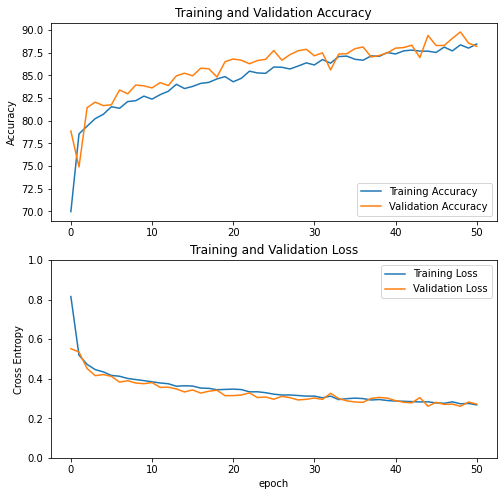

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [42]:
# !pip install playsound

# from playsound import playsound
  
# # for playing note.wav file
# playsound('/path/note.wav')
# print('playing sound using  playsound')

In [43]:
# import os, os.path

# # simple version for working with CWD
# print len([name for name in os.listdir('') if os.path.isfile(name)])

In [44]:
torch.save(model.state_dict(), '/kaggle/working/CornModelV1.pk1')

In [45]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('CornModelV1.pt') # Save

import os 
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'CornModelV1.pt')

import os 
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'CornModelV1.pk1')

/kaggle/working/CornModelV1.pk1